# Tabular Data Classification Example

In this example, we demonstrate how to use dlpy to build a simple neural network for tabular data classification problems. 

The breast cancer dataset we used here is contained in the sklearn package. More details about the data can be found here:https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset

Key steps involved:
1. Upload data to the server
2. Build and train a fully connected feedforward neural network model with dlpy.
3. Predict on the testing dataset.
4. Evaluate confusion matrix
5. Assess and visualize ROC curve, calculate Area under the curve(AUC). 
6. Evaluate precision recall curve, f1 score and average precision score. 

### 1. Import python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import load_breast_cancer #The dataset is from sklearn package, with version >= 0.20.1
from swat.cas import datamsghandlers
from swat import CAS, CASTable
from dlpy import Model, Sequential
from dlpy.model import Optimizer, AdamSolver
from dlpy.layers import * 
from dlpy.splitting import two_way_split
from dlpy.metrics import (accuracy_score, confusion_matrix, plot_roc, 
                          plot_precision_recall, roc_auc_score, f1_score, average_precision_score)
%matplotlib inline

### 2. Connect to CAS server

In [2]:
conn = CAS('host_name', port_number)

### 3. Load examples dataset from scikit-learn

In [3]:
# load the breast cancer data
bc_data = load_breast_cancer() 

# Get data into two pandas dataframes for the predictors(bc_x_df) and target(bc_y_df). 
bc_x_df = pd.DataFrame(bc_data['data'], columns=bc_data['feature_names'])
bc_y_df = pd.DataFrame(bc_data['target'], columns=['target_class'])

# Concatenate the data into one dataframe
bc_df = pd.concat([bc_x_df, bc_y_df], axis=1)

In [4]:
bc_df.loc[:10]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target_class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,0


There are 212 malignant tumors ('0' in the data), 357 benign tumors ('1' in the data)

In [5]:
bc_df.target_class.value_counts()

1    357
0    212
Name: target_class, dtype: int64

### 4. Upload the pandas dataframe to server

In [6]:
tbl = conn.upload_frame(bc_df, casout=dict(name='bc_df', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table BC_DF in caslib CASUSER(RLstat).
NOTE: The table BC_DF has been created in caslib CASUSER(RLstat) from binary data uploaded to Cloud Analytic Services.


### 5. Split the data

Here we show the train-test spliting using the `two_way_split` function in `dlpy.splitting`. It performs random sampling and split the data into `train_tbl` and `test_tbl` (on the server side). It is perferred over splitting on the local client side when the data is large, or already hosted on the server. 

In [7]:
train_tbl, test_tbl = two_way_split(tbl, test_rate=30, seed=1234, stratify=False, im_table=False)

### 6. Build one layer fully connected neural network

Network specifications:
1. One dense layer
2. Activation function: relu
3. Number of neurons: 20
4. Output layer loss function: entropy.
5. Output layer activation function: softmax (to match with entropy).
6. number of neuron in output layer: n=2 (two classes).

In [8]:
model1 = Sequential(conn, model_table=CASTable('simple_dnn_classifier', replace=True))
model1.add(InputLayer(std='STD'))
model1.add(Dense(20, act='relu'))
model1.add(OutputLayer(act='softmax', n=2,  error='entropy'))

NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


### 7. Train fully connected neural network

Here we specify the optimizer to show a **scheduled training approach**:

We use `learning_rate_policy='step'` to specify stepwise learning rate decreasing policy. The step size is `step_size=5`, which means every 5 epochs, the `learning_rate` will be multiplied by factor `gamma=0.9`. In addition, we set `log_level=2` to visualize the training log.

In [9]:
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.005, learning_rate_policy='step', 
                                           gamma=0.9, step_size=5), 
                      mini_batch_size=4, seed=1234, max_epochs=50, log_level=2)

result = model1.fit(train_tbl, inputs=bc_x_df.columns.tolist(), nominals=['target_class'], 
                    target='target_class', optimizer=optimizer)

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 662.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.01 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: target_class
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0:            0
NOTE:  Level      1:            1
NOTE:  Number of input variables:    30
NOTE:  Number of numeric input variables:     30
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0         0.005           1.074     0.6508     0.00
NOTE:  1         0.005           0.618     0.3492     0.00
NOTE:  2         0.005          0.3906    0.09296     0.00
NOTE:  3   

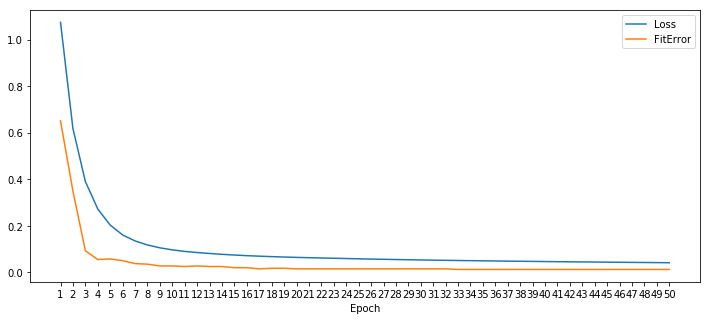

In [10]:
# Plot the training history.
model1.plot_training_history()

### 8. Evaluate testing results with various classification metrics

Note: for example simplicity, we just evaluate the testing results. Feel free to check the training result by changing `test_tbl` to `train_tbl`.

In [11]:
test_result = model1.predict(test_tbl)
test_result_table = model1.valid_res_tbl

NOTE: Due to data distribution, miniBatchSize has been limited to 6.


In [12]:
test_result_table.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target_class,P_target_class0,P_target_class1,I_target_class,_DL_PredP_,_DL_PredLevel_
0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,0.4504,0.24300,0.3613,0.08758,0.0,1.000000,3.492930e-07,0,1.000000,0.0
1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,0.6869,0.25750,0.6638,0.17300,0.0,0.998898,1.101607e-03,0,0.998898,0.0
2,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,0.5355,0.17410,0.3985,0.12440,0.0,0.971757,2.824266e-02,0,0.971757,0.0
3,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,0.5390,0.20600,0.4378,0.10720,0.0,0.999097,9.028290e-04,0,0.999097,0.0
4,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,...,0.1459,0.09975,0.2948,0.08452,0.0,0.788165,2.118350e-01,0,0.788165,0.0


In [13]:
# Show the confusion matrix
display(confusion_matrix(test_result_table['target_class'], test_result_table['I_target_class']))

I_target_class,0.0,1.0
target_class,,
0.0,51.0,4.0
1.0,3.0,113.0


In [14]:
# Calculate the accuracy score
acc_score = accuracy_score(test_result_table['target_class'], test_result_table['I_target_class'])
print('the accuracy score is {:.6f}'.format(acc_score))

the accuracy score is 0.959064


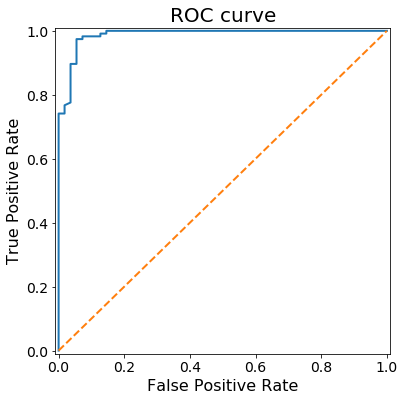

In [15]:
# Plot the ROC curve for target_class = 1. 
plot_roc(test_result_table['target_class'], test_result_table['P_target_class1'], pos_label=1, figsize=(6,6), linewidth=2)

In [16]:
# Calculate the area under the ROC curve.
auc_of_roc = roc_auc_score(test_result_table['target_class'], test_result_table['P_target_class1'], pos_label=1)
print('the area under the ROC curve is {:.6f}'.format(auc_of_roc))

the area under the ROC curve is 0.987696


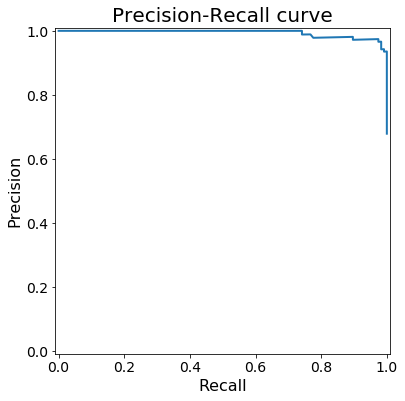

In [17]:
# Plot the precision recall curve for target_class = 1. 
plot_precision_recall(test_result_table['target_class'], test_result_table['P_target_class1'], pos_label=1, figsize=(6,6), 
                      linewidth=2)

In [18]:
# Calculate the average precision score
ap = average_precision_score(test_result_table['target_class'], test_result_table['P_target_class1'], pos_label=1)
print('the average precision score is {:.6f}'.format(ap))

the average precision score is 0.993677


In [19]:
# Calculate the f1 score
f1sc = f1_score(test_result_table['target_class'], test_result_table['I_target_class'], pos_label=1)
print('the f1 score is {:.6f}'.format(f1sc))

the f1 score is 0.969957


**Note: For more classification related metrics, please see the dlpy.metrics**